# Convergence rates (1D Poisson equation)

In this notebook we numerically verify the theoretical converge rates of the finite element discretization of an elliptic problem.

More specifically, we consider the Poisson equation
$$ - \frac{\partial^2 u}{\partial^2 x} = f(x)  \quad \forall x \in (0,1), $$
with homegeneuos Dirichlet boundary conditions $u(0) = u(1) = 0$ and forcing term $f(x) = \sin(5 \pi x)$.
The analytical solution is $u_{\rm ex} = \frac{1}{(5\pi)^2} \sin(5\pi x)$.

To obtain the weak form, we let $\Omega = (0,1)$ and we define the functional space $V = H^1_0(\Omega)$.
Then, the weak formulation of the boundary value problem reads

$$ \int_0^1 \frac{\partial u}{\partial x} \frac{\partial v}{\partial x} \, dx = \int_0^1 f\,v \, dx, \quad \forall v \in V. $$

Finally, to obtain the finite element discretization we introduce a uniform triangulation (mesh) $\mathcal{T}_h$ of the domain $\Omega$ and finite dimensional subspace $V_h \subset V$. 
$V_h$ consists of globally continuous functions that are piecewise polynomial with degree $k$ on each element $\tau$ of the mesh $\mathcal{T}_h$, that is
$$ V_h := \left\{ v_h \in V \; | \; \left. v_h \right|_{\tau} \in P^{k} \quad  \forall \tau \in \mathcal{T}_h \right\},$$
where $P^{k}$ denotes the space of polynomial function with degree $k$.

Using the abouve notation, the finite element discretization of the BVP reads:

Find $u_h \in V_h$ such that
$$ \int_0^1 \frac{\partial u_h}{\partial x} \frac{\partial v_h}{\partial x} \, dx = \int_0^1 f\,v_h \, dx, \quad \forall v_h \in V_h.$$

## Finite element error estimates

Assuming that the analytical solution is regular enough (i.e. $u_{\rm ex} \in H^{k+1}$), the following error estimates hold

- Energy norm:
$$ \left\| u_{\rm ex} - u_h \right\|_{\rm energy} := \left( \int_0^1 \left|\frac{du_{\rm ex}}{dx} - \frac{du_{h}}{dx}\right|^2 dx \right)^{\frac{1}{2}} = \mathcal{O}(h^k), $$

- $L^2(\Omega)$ norm:
$$ \left\| u_{\rm ex} - u_h \right\|_{L^2} := \left( \int_0^1 \left|u_{\rm ex} - u_{h}\right|^2 dx \right)^{\frac{1}{2}} = \mathcal{O}(h^{k+1}), $$

where $h$ denote the mesh size. For a uniform 1D mesh of the unit interval $h = \frac{1}{n}$ where $n$ is the number of mesh elements.

## Step 1. Import modules

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from dolfin import *
import numpy as np

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
set_log_active(False)

## Step 2. Finite element solution of the BVP

Here we implement a function `solveBVP` that computes the finite element discretizions and solves the discretized problem.

As input, it takes the number of mesh elements `n` and the polynomial degree `degree`. As output, it returns the errors in the $L^2$ and energy norm.

In [2]:
def solveBVP(n, degree):
    # 1. Mesh and finite element space
    mesh = UnitIntervalMesh(n)
    Vh = FunctionSpace(mesh, 'CG', degree)

    # 2. Define the right hand side f
    f = Expression("sin(omega*x[0])", omega = 5*pi, degree = 5)
    
    # 3. Define the Dirichlet boundary condition
    u_bc = Constant(0.)
    def dirichlet_boundary(x,on_boundary):
        return on_boundary
    bcs = [DirichletBC(Vh, u_bc, dirichlet_boundary)]

    # 4. Define the weak form
    uh = TrialFunction(Vh)
    vh = TestFunction(Vh)
    A_form = inner(grad(uh), grad(vh))*dx
    b_form = inner(f,vh)*dx

    # 5. Assemble and solve the finite element discrete problem
    A, b = assemble_system(A_form, b_form, bcs)
    uh = Function(Vh)
    solve(A, uh.vector(), b, "cg", "petsc_amg")

    # 6. Compute error norms
    u_ex = Expression("(1./(omega*omega))*sin(omega*x[0])", omega = 5*pi, degree = 5)
    err_L2 = np.sqrt( assemble((uh-u_ex)**2*dx) ) 

    grad_u_ex = Expression( "(1./(omega))*cos(omega*x[0])" , omega = 5*pi, degree = 5)
    err_energy = np.sqrt( assemble((grad(uh)[0]-grad_u_ex)**2*dx) )
    
    return err_L2, err_energy

## Step 3. Generate the converges plots

The function `make_convergence_plot` generates the converges plots.

It takes as input a `numpy.array n` that contains a sequence of number of mesh elements and the polynomial degree `degree` of the finite element space.

It plots the energy norm of the error (in red) and the $L^2$ norm of the error (in blue) in a loglog scale. The $x$-axis is the mesh size $h$.

The slope of the lines in the loglog scale represents the order of converge and dotted lines represents the expected convergence rate.

In [3]:
def make_convergence_plot(n, degree):
    errs_L2 = np.zeros(n.shape)
    errs_En = np.zeros(n.shape)
    
    for i in np.arange(n.shape[0]):
        print (i, ": Solving problem on a mesh with", n[i], " elements.")
        eL2, eE = solveBVP(n[i], degree)
        errs_L2[i] = eL2
        errs_En[i] = eE
        
    h = np.ones(n.shape)/n
    plt.loglog(h, errs_L2, '-*b', label='L2')
    plt.loglog(h, errs_En, '-*r', label='Energy')
    plt.loglog(h, .7*np.power(h,degree+1)*errs_L2[0]/np.power(h[0],degree+1), '--b', label = 'order {0}'.format(degree+1))
    plt.loglog(h, .7*np.power(h,degree)*errs_En[0]/np.power(h[0],degree), '--r', label = 'order {0}'.format(degree))
    plt.legend()
    plt.grid()
    plt.show()
    

## Converges rate of piecewise linear finite element (k=1)

0 : Solving problem on a mesh with 4  elements.
1 : Solving problem on a mesh with 8  elements.
2 : Solving problem on a mesh with 16  elements.
3 : Solving problem on a mesh with 32  elements.
4 : Solving problem on a mesh with 64  elements.


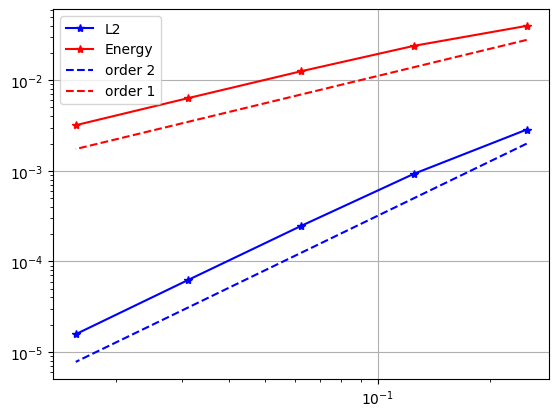

In [4]:
degree = 1
n = np.power(2, np.arange(2,7)) # n = [2^2, 2^3, 2^4 2^5, 2^6]
make_convergence_plot(n, degree)

## Converges rate of piecewise quadratic finite element (k=2)

0 : Solving problem on a mesh with 4  elements.
1 : Solving problem on a mesh with 8  elements.
2 : Solving problem on a mesh with 16  elements.
3 : Solving problem on a mesh with 32  elements.
4 : Solving problem on a mesh with 64  elements.


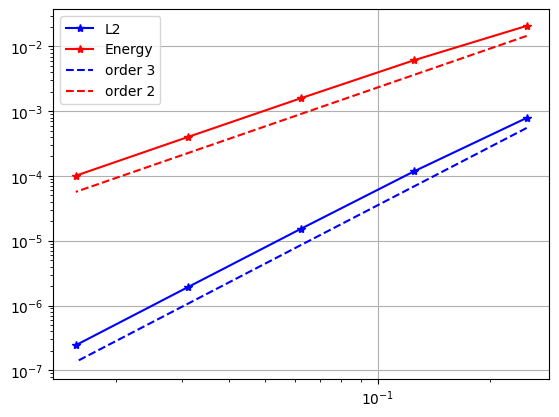

In [5]:
degree = 2
make_convergence_plot(n, degree)